In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import seaborn as sns

plt.style.use("bmh")

$$
\partial_{t} u + u \partial_x u = \nu \partial_{xx} ^2 u
$$

## TVD Scheme

In [17]:
Nx= 200
#cfl= 0.2
tmax = 1 # time 0 ~ 1
viscosity_coeff = (0.01/np.pi)

x = np.linspace(-1,1, 200)

#t = 0  , I.C
u = -1*np.sin(np.pi * x)
dx = abs(x[1]-x[0])

dt = 0.002# cfl * dx / np.max(np.abs(u))

nt = int(tmax/ dt) #+ 1

uf = np.zeros((nt,Nx))
uf[0, :] = u

print(nt)
print(dt)
print(nt * dt, tmax )

500
0.002
1.0 1


In [18]:
print(nt)
print(dt)
print(nt*dt, tmax)

500
0.002
1.0 1


In [19]:
def f(u):
    y = 0.5 * u**2
    yp = u
    return y, yp

In [20]:
def minmod(a,b):
    return 0.5 * (np.sign(a)+ np.sign(b)) * np.minimum(np.abs(a), np.abs(b))

In [21]:
def RHS(u, dx, viscosity_coeff):
    #diffusion term
    diffusion_term = viscosity_coeff * (np.roll(u,1)- 2*u + np.roll(u,-1))/ dx**2

    # convection term
    ux = minmod((u - np.roll(u,1))/dx ,  (np.roll(u,-1) - u)/dx)
    
    uL = np.roll(u -0.5 * dx*ux,1)
    uR = u -0.5 * dx*ux
    fL,fpL = f(uL)
    fR,fpR = f(uR)
    a = np.maximum(np.abs(fpL), np.abs(fpR))
    
    H =0.5 * (fL + fR - a * (uR - uL))
    
    conv_term  = -(np.roll(H,-1)-H)/dx
    
    y = conv_term + diffusion_term
    return y

In [22]:
for i in range(1, nt):
    u1 = u + dt * RHS(u,dx,viscosity_coeff)
    u = 0.5 * u + 0.5 * (u1 + dt * RHS(u1, dx,viscosity_coeff))
    uf[i, :] = u

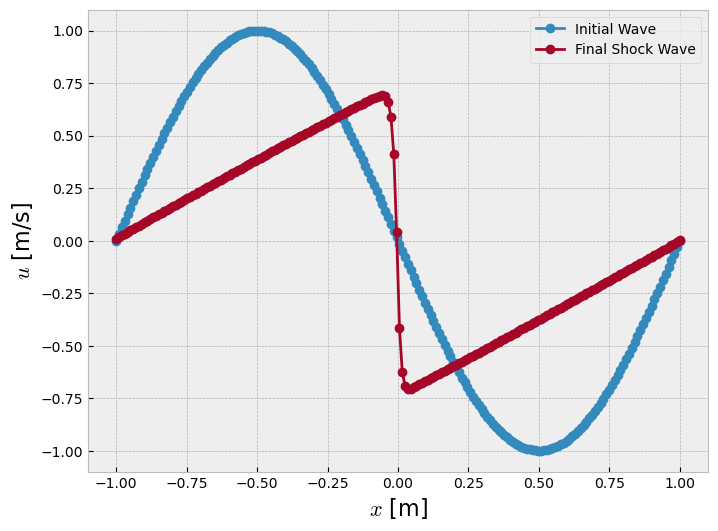

In [23]:
plt.figure(figsize=(8,6));
plt.plot(x, uf[0], "-o", label="Initial Wave");
plt.plot(x, uf[-1], "-o", label="Final Shock Wave");
plt.xlabel(r"$x$ [m]", fontsize=16);
plt.ylabel(r"$u$ [m/s]", fontsize=16);
plt.legend();

In [24]:
plt.figure(figsize=(5, 3), dpi=3e3);
sns.heatmap(uf.T)

<Axes: >

## PINNs

$x, t$ -> $u$

In [25]:
# NN def
class NN(torch.nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2,20), # x & t -> 20 neurons
            torch.nn.Tanh(), # activation funct.
            torch.nn.Linear(20, 30), #20 neurons -> 30 neurons
            torch.nn.Tanh(), #act, funct
            torch.nn.Linear(30, 30), #30-> 20
            torch.nn.Tanh(), #af
            torch.nn.Linear(30, 20), # 30 ->20
            torch.nn.Tanh(), #af
            torch.nn.Linear(20, 20), # 20 -> 20
            torch.nn.Tanh(), #af
            torch.nn.Linear(20, 1), # 20 -> 1
        )
        
    def forward(self, x):
        out = self.net(x)
        return out

In [26]:
# data = ICs & BCs
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
        self.model = NN().to(device)
        
        # comp. domain 
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1,1+self.h, self.h)
        t = torch.arange(0,1+self.k, self.k)
        
        self.X = torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
        
        # train data
        bc1 = torch.stack(torch.meshgrid(x[0],t)).reshape(2,-1).T # first spatial element
        bc2 = torch.stack(torch.meshgrid(x[-1],t)).reshape(2,-1).T # last spatial element
        ic  = torch.stack(torch.meshgrid(x,t[0])).reshape(2,-1).T # initial cond
        self.X_train = torch.cat([bc1, bc2, ic])
        
        y_bc1 = torch.zeros(len(bc1)) # u at the bc1
        y_bc2 = torch.zeros(len(bc2)) # u at the bc2 
        y_ic  = -torch.sin(np.pi * ic[:,0]) # u at the ic
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True
        
        # optimizer setting
        self.adam =  torch.optim.Adam(self.model.parameters())
        #Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50000,
            max_eval = 50000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
    
    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred,self.y_train)
        
        u = self.model(self.X)
        
        du_dX = torch.autograd.grad(
            u,
            self.X,
            grad_outputs = torch.ones_like(u),
            create_graph = True,
            retain_graph = True
        )[0]
        
        du_dt = du_dX[:,1]
        du_dx = du_dX[:,0]
        
        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]
        
        du_dxx = du_dXX[:,0]
        
        loss_pde = self.criterion(du_dt + u.squeeze()*du_dx , (0.01/np.pi) * du_dxx)
        
        loss = loss_pde + loss_data
        loss.backward()
        
        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter+1
        
        return loss
    
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
    
    def eval_(self):
        self.model.eval()

In [27]:
# training 

net = Net()
net.train()
net.model.eval()

/home/arya/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at /opt/conda/conda-bld/pytorch_1702400430266/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/arya/anaconda3/envs/pytorch/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400430266/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.13126124441623688
200 0.08860693871974945
300 0.06774137914180756
400 0.03317265212535858
500 0.024996787309646606
600 0.02102389745414257
700 0.01833113469183445
800 0.017735928297042847
900 0.015293445438146591
1000 0.016081709414720535
1100 0.008143894374370575
1200 0.004813863895833492
1300 0.0025115020107477903
1400 0.0015162946656346321
1500 0.0010574787156656384
1600 0.0007856721058487892
1700 0.0005834568291902542
1800 0.0004004723159596324
1900 0.00030930794309824705
2000 0.0002433912013657391
2100 0.0001854956935858354
2200 0.00015322629769798368
2300 0.00013802490138914436
2400 0.00012483607861213386
2500 0.00010744964674813673
2600 9.786695591174066e-05
2700 8.812679152470082e-05
2800 7.595780334668234e-05
2900 6.903294706717134e-05
3000 6.258142821025103e-05
3100 5.6702367146499455e-05
3200 5.222570325713605e-05
3300 4.708528285846114e-05
3400 4.4952379539608955e-05
3500 4.2011750338133425e-05
3600 4.0217371861217543e-05
3700 3.8639547710772604e-05
3800 3.79820012312

NN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [28]:
h = 0.01 # dx
k = 0.01 # dt

x = torch.arange(-1,1,h)
t = torch.arange(0,1,k)

X= torch.stack(torch.meshgrid(x,t)).reshape(2,-1).T
X= X.to(net.X.device)

In [29]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x), len(t)).cpu().numpy()

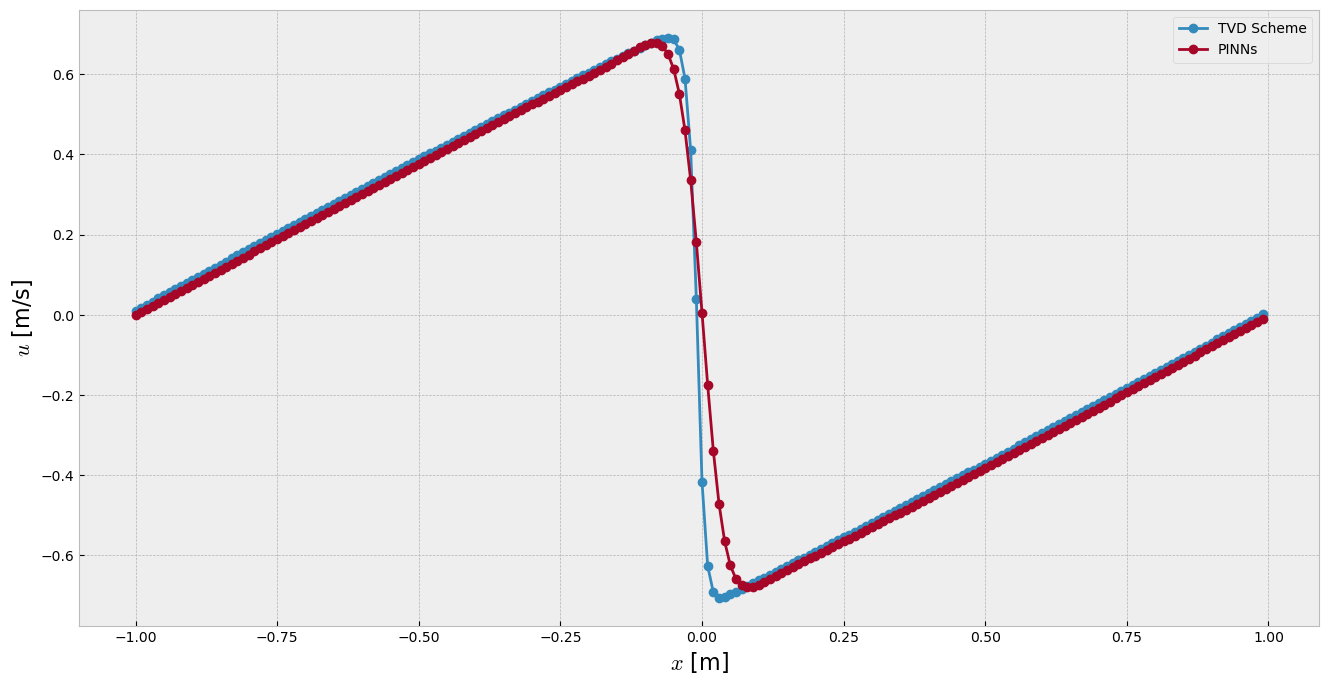

In [31]:
plt.figure(figsize=(16, 8));
plt.plot(x, uf[-1], "-o", label="TVD Scheme");
plt.plot(x, y_pred[:,-1], "-o", label="PINNs");
plt.xlabel(r"$x$ [m]", fontsize=16);
plt.ylabel(r"$u$ [m/s]", fontsize=16);
plt.legend();